# RNN으로 IMDB 영화리뷰 감정 분류하기
## simpleRNN
### 순환 신경망 RNN
* 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 **상태(state)**에 저장
* 내부에 loop를 가진 신경망

### numpy로 구현한 간단한 RNN
> RNN 정방향 계산 구현
* input: 크기 (timesteps, input_feature)인 2D 텐서로 인코딩 된 벡터의 시퀀스
    * 시퀀스는 timestep을 따라서 반복됨
    * 각 timestep t에서 현재 상태와 입력을 연결하여 출력으로 계산 -> 출력을 다음 스텝의 상태로 설정
    * 1번째 timestep은 초기상태(0 벡터)로 상태 초기화

In [6]:
import numpy as np

timesteps = 100 # 입력시퀀스에 있는 타임스텝 수
input_features = 32 
output_features = 64

inputs = np.random.random((timesteps, input_features)) # 입력 데이터: 예제를 위해 생성한 난수

state_t = np.zeros((output_features)) # 초기상태: 모두 0인 벡터

W = np.random.random((output_features, input_features)) 
U = np.random.random((output_features, output_features)) 
b = np.random.random((output_features,)) 

successive_outputs = []
for input_t in inputs:
    # 입력과 현재 상태(이전 출력)를 연결하여 현재 출력 얻기
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # 출력을 리스트에 저장
    successive_outputs.append(output_t)
    # 다음 타임스텝을 위해 네트워크 상태 업데이트
    state_t = output_t
# 최종 출력    
final_output_sequence = np.stack(successive_outputs, axis=0)

---
## simple RNN으로 영화리뷰 이진분류
### IMDB 데이터 전처리

In [7]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


### 임베딩 층과 SimpleRNN층을 사용한 모델 훈련

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
model.save_weights('simpleRNN.h5')

Epoch 1/10
157/157 [==============================] - 105s 662ms/step - loss: 0.6186 - acc: 0.6349 - val_loss: 0.4533 - val_acc: 0.7992
Epoch 2/10
157/157 [==============================] - 100s 637ms/step - loss: 0.3864 - acc: 0.8330 - val_loss: 0.4631 - val_acc: 0.7972
Epoch 3/10
157/157 [==============================] - 104s 660ms/step - loss: 0.2879 - acc: 0.8869 - val_loss: 0.4773 - val_acc: 0.7688
Epoch 4/10
157/157 [==============================] - 99s 633ms/step - loss: 0.2300 - acc: 0.9111 - val_loss: 0.4157 - val_acc: 0.8182
Epoch 5/10
157/157 [==============================] - 100s 640ms/step - loss: 0.1700 - acc: 0.9362 - val_loss: 0.4308 - val_acc: 0.8136
Epoch 6/10
157/157 [==============================] - 99s 631ms/step - loss: 0.1202 - acc: 0.9561 - val_loss: 0.4555 - val_acc: 0.8356
Epoch 7/10
157/157 [==============================] - 99s 628ms/step - loss: 0.0803 - acc: 0.9743 - val_loss: 0.4940 - val_acc: 0.8394
Epoch 8/10
157/157 [==============================]

### simpleRNN 결과 그래프

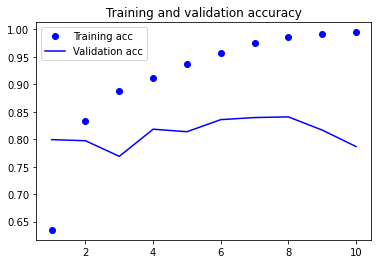

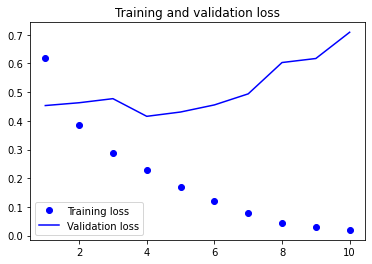

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### simple RNN 테스트 결과

In [9]:
score = model.evaluate(input_test, y_test, verbose=1)
print("test acc: %.2f"%(score[1]))

782/782 [==============================] - 41s 52ms/step - loss: 0.6992 - acc: 0.7869
test acc: 0.79


---
## LSTM으로 영화리뷰 이진분류
### LSTM을 사용한 모델 훈련

In [11]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
model.save_weights('LSTM.h5')

Epoch 1/10
157/157 [==============================] - 18s 89ms/step - loss: 0.5391 - acc: 0.7456 - val_loss: 0.3875 - val_acc: 0.8492
Epoch 2/10
157/157 [==============================] - 13s 84ms/step - loss: 0.3094 - acc: 0.8797 - val_loss: 0.2895 - val_acc: 0.8808
Epoch 3/10
157/157 [==============================] - 13s 83ms/step - loss: 0.2377 - acc: 0.9089 - val_loss: 0.3021 - val_acc: 0.8810
Epoch 4/10
157/157 [==============================] - 13s 81ms/step - loss: 0.2039 - acc: 0.9235 - val_loss: 0.3174 - val_acc: 0.8810
Epoch 5/10
157/157 [==============================] - 13s 81ms/step - loss: 0.1787 - acc: 0.9344 - val_loss: 0.3425 - val_acc: 0.8832
Epoch 6/10
157/157 [==============================] - 13s 81ms/step - loss: 0.1636 - acc: 0.9413 - val_loss: 0.3584 - val_acc: 0.8698
Epoch 7/10
157/157 [==============================] - 13s 81ms/step - loss: 0.1462 - acc: 0.9488 - val_loss: 0.3022 - val_acc: 0.8888
Epoch 8/10
157/157 [==============================] - 13s 81ms

### LSTM 결과 그래프

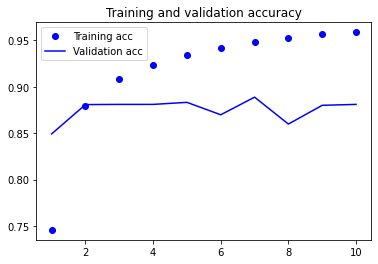

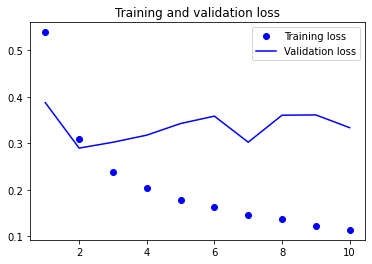

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
score = model.evaluate(input_test, y_test, verbose=1)
print("test acc: %.2f"%(score[1]))

782/782 [==============================] - 25s 32ms/step - loss: 0.3792 - acc: 0.8585
test acc: 0.86


---
## 양방향 LSTM
### 양방향 RNN


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras import backend as K
K.clear_session()

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)
model.save_weights('bidirectical_LSTM.h5')

Epoch 1/10
157/157 [==============================] - 34s 194ms/step - loss: 0.5124 - acc: 0.7548 - val_loss: 0.4178 - val_acc: 0.8110
Epoch 2/10
157/157 [==============================] - 29s 186ms/step - loss: 0.3015 - acc: 0.8806 - val_loss: 0.4122 - val_acc: 0.8390
Epoch 3/10
157/157 [==============================] - 29s 188ms/step - loss: 0.2389 - acc: 0.9118 - val_loss: 0.3030 - val_acc: 0.8774
Epoch 4/10
157/157 [==============================] - 29s 187ms/step - loss: 0.1975 - acc: 0.9291 - val_loss: 0.3173 - val_acc: 0.8696
Epoch 5/10
157/157 [==============================] - 30s 188ms/step - loss: 0.1792 - acc: 0.9358 - val_loss: 0.3337 - val_acc: 0.8674
Epoch 6/10
157/157 [==============================] - 29s 186ms/step - loss: 0.1554 - acc: 0.9449 - val_loss: 0.3209 - val_acc: 0.8816
Epoch 7/10
157/157 [==============================] - 29s 186ms/step - loss: 0.1425 - acc: 0.9491 - val_loss: 0.3242 - val_acc: 0.8842
Epoch 8/10
157/157 [==============================] - 2

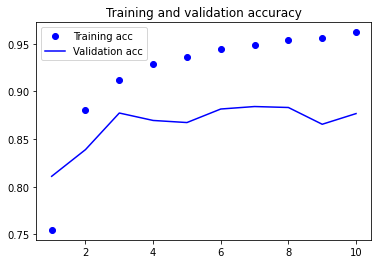

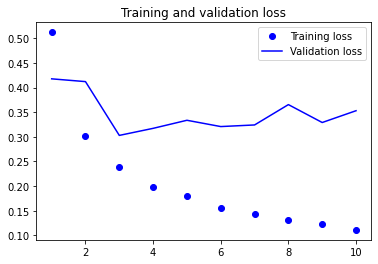

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
score = model.evaluate(input_test, y_test, verbose=1)
print("test acc: %.2f"%(score[1]))

782/782 [==============================] - 52s 66ms/step - loss: 0.4143 - acc: 0.8597
test acc: 0.86
